In [1]:
import pandas as pd
from ta import *
import matplotlib.pyplot as plt

import numpy as np
import math
from math import sqrt 

# Read USD/KZT prices
df = pd.read_csv("USD_KZT Historical Data.csv", header=0, index_col=0, parse_dates=[0])
df = df.rename(columns={"Price":"Close"})
df = df.iloc[::-1]

# Read oil prices
oil = pd.read_csv("Brent Oil Futures Historical Data.csv", header=0, index_col=0, parse_dates=[0])
oil = oil.iloc[::-1]

# Add oilprice as a new column into KZT/USD dataframe
df['Oilprice'] = oil['Price'].asof(df.index)

# Fill nan values with 0, min value or first non-nan value
#df['Oilprice'] = df['Oilprice'].fillna(df['Oilprice'].min())
df['Oilprice'] = df['Oilprice'].fillna(df['Oilprice'][1])
#df = df.fillna(0)


/Users/angiemelomangie/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


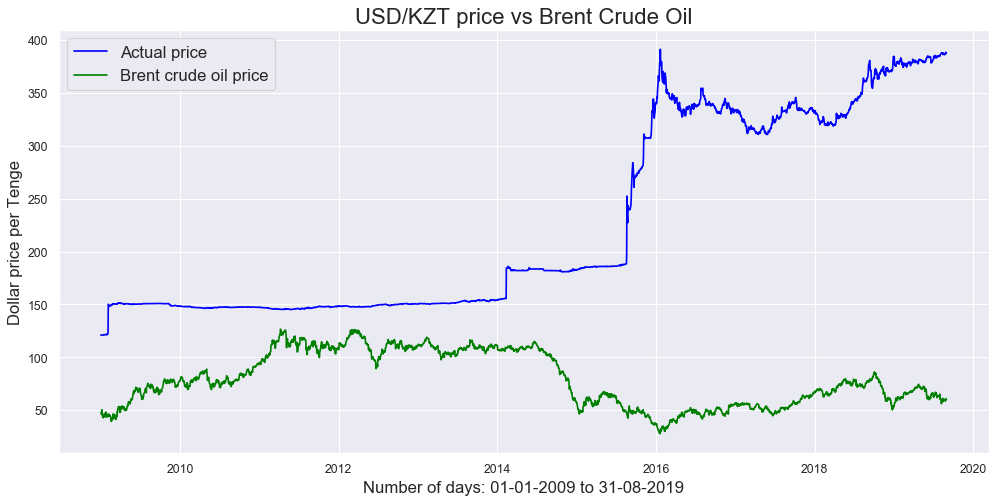

In [2]:
import seaborn as sns
sns.set()

plt.figure(figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(df['Close'], label='Actual price',color='blue')
plt.plot(df['Oilprice'], label = 'Brent crude oil price', color = 'green')

plt.title('USD/KZT price vs Brent Crude Oil', fontsize=20)
plt.xlabel("Number of days: 01-01-2009 to 31-08-2019", fontsize=15)
plt.ylabel("Dollar price per Tenge", fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [6]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.layers import Bidirectional
import time
from sklearn.preprocessing import MinMaxScaler

price = np.array(df['Close'])
oil = np.array(df['Oilprice'])

train_size = int(len(price)*0.8)
test_size = len(price) - train_size

train_index = np.arange(0, train_size)
test_index = np.arange(train_size, len(price))

price_train, price_test = price[train_index], price[test_index]
oil_train, oil_test = oil[train_index], oil[test_index]
# print(len(price_train), len(price_test))
# print(len(oil_train), len(oil_test))

# convert to [rows, columns] structure
price_train = price_train.reshape((len(price_train), 1))
oil_train = oil_train.reshape((len(oil_train), 1))

price_test = price_test.reshape((len(price_test), 1))
oil_test = oil_test.reshape((len(oil_test), 1))

# horizontally stack columns
train_data = np.hstack((price_train, oil_train))
test_data = np.hstack((price_test, oil_test))

# # Data normalization
# scaler = MinMaxScaler(feature_range=(0, 1))
# train_data = scaler.fit_transform(train_data)
# test_data = scaler.transform(test_data)


# split a multivariate sequence into samples
def split_data(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Choose a number of time steps for look back
n_steps = 10

X, y = split_data(train_data, n_steps)
n_features = X.shape[2]

X2, y2 = split_data(test_data, n_steps)


# # Vanilla LSTM
# model = Sequential()
# model.add(LSTM(36, activation='relu', input_shape=(n_steps, n_features)))
# model.add(LSTM(36, activation='relu')) #, input_shape=(n_steps, n_features)))
# model.add(Dense(n_features))
# model.compile(optimizer='adam', loss='mse')

# # Bidirectional LSTM
model = Sequential()
model.add(Bidirectional(LSTM(36, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',  loss='mse', metrics=['mae', 'mape'])  # loss='mse'


train_error = []
test_error = []
train_error_mape = []
test_error_mape = []

start_time = time.time()
for i in range(5):
    model.fit(X, y, epochs=40, batch_size=40, verbose=0)
    training_scores = model.evaluate(X, y, verbose=0)
    testing_scores= model.evaluate(X2, y2, verbose=0)
    #print(training_scores[0])
    train_error.append(training_scores[0])
    test_error.append(testing_scores[0])
    train_error_mape.append(training_scores[2])
    test_error_mape.append(testing_scores[2])
    
train_time = time.time() - start_time
print('Train Time: %.2f sec' % (train_time)) 

train_error_avg = np.sum(train_error)/len(train_error)
train_mape = np.sum(train_error_mape)/len(train_error_mape)
print('Average Train Score: %.2f MSE (%.2f RMSE) %.2f (MAPE)' % (train_error_avg, math.sqrt(train_error_avg), train_mape))

test_error_avg = np.sum(test_error)/len(test_error)
test_mape = np.sum(test_error_mape)/len(test_error_mape)
print('Average Test Score: %.2f MSE (%.2f RMSE) %.2f (MAPE)' % (test_error_avg, math.sqrt(test_error_avg), test_mape))

training_prediction = model.predict(X)
testing_prediction = model.predict(X2)

# Inverse scaling of normalized data
# training_prediction = scaler.inverse_transform(training_prediction)
# testing_prediction = scaler.inverse_transform(testing_prediction)

Train Time: 145.48 sec
Average Train Score: 9.57 MSE (3.09 RMSE) 0.79 (MAPE)
Average Test Score: 23.35 MSE (4.83 RMSE) 0.98 (MAPE)


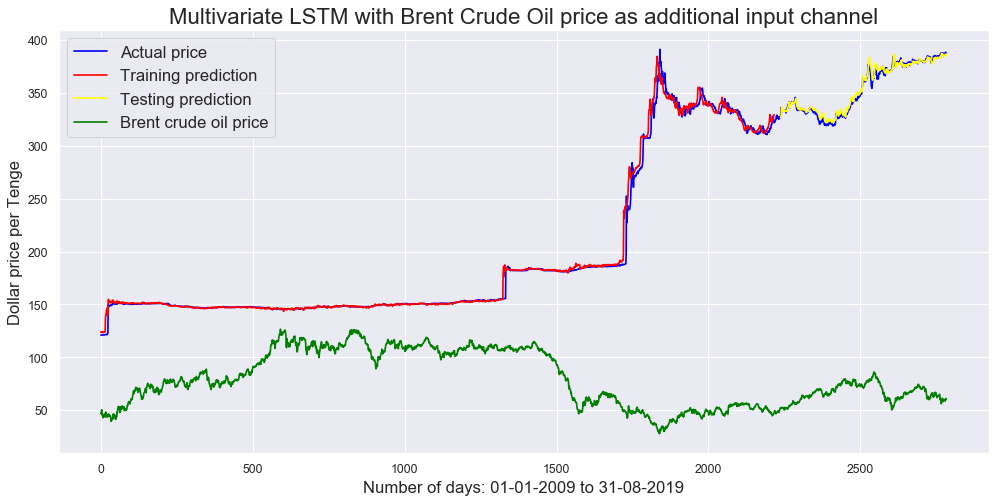

In [8]:
import seaborn as sns
sns.set()

plt.figure(figsize=(15,7), dpi=80, facecolor='w', edgecolor='k')

plt.plot(price, label='Actual price',color='blue')
plt.plot(training_prediction, label='Training prediction', color='red')
plt.plot(test_index[len(test_index)-len(testing_prediction):], testing_prediction, label= 'Testing prediction',color='yellow')
plt.plot(oil, label = 'Brent crude oil price', color = 'green')

plt.title('Multivariate LSTM with Brent Crude Oil price as additional input channel', fontsize=20)
plt.xlabel("Number of days: 01-01-2009 to 31-08-2019", fontsize=15)
plt.ylabel("Dollar price per Tenge", fontsize=15)
plt.legend(fontsize=15)
plt.show()